<a href="https://colab.research.google.com/github/yifeiw7/miscellaneous/blob/main/Lab5_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/19v-bbh_IG0e8xcj64xi3WGvoRZr7WMR6/view?usp=sharing

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [1]:
!pip install torchtext==0.6 torch==1.11


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 505.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.17.1
    Uninstalling torchtext-0.17.1:
      Successfully uninstalled torchtext-0.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 1.11.0 which is incompatible.
torchdata 0.7.1 requires torch>=2, but you have torch 1.11.0 which is incompatible.
torchvision 0.17.1+cu121 requires torch==2.2.1, but you have torch 1.11.0 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [3]:

for line in open('/SMSSpamCollection'):
    if line.split()[0] == "spam":
      print('Spam Label: ', "spam")
      print("Spam message: ", line)
      break

for line in open('/SMSSpamCollection'):
    if line.split()[0] == "ham":
      print('Non-spam Label: ', "ham")
      print("Non-spam Message: ", line)
      break


Spam Label:  spam
Spam message:  spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Non-spam Label:  ham
Non-spam Message:  ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [4]:
num_spam = 0
num_ham = 0
for line in open('/SMSSpamCollection'):
    if line.split()[0] == "spam":
      num_spam += 1
    else:
      num_ham += 1

print("Number of spam messages:", num_spam)
print("Number of non-spam messages:", num_ham)

Number of spam messages: 747
Number of non-spam messages: 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [ ]:
# Advantage
# 1. text messages are usually shorter than regular sentences and contain mis-spelled words or slangs
#    so modelling them as sequence of characters can better capture the semantics
# 2. only 26 letters plus a few other characters are needed, the number of types of tokens is small

# Disadvantage
# 1. each message will be parsed into more tokens which makes the model take longer to train and run
# 2. more possible token combinations to learn than using words, the model may be more likely to overfit
#    or underfit due to complexity of the data


### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [32]:
import torchtext

text_field = torchtext.data.Field(sequential=True,
                                  tokenize=lambda x: x,
                                  include_lengths=True,
                                  batch_first=True,
                                  use_vocab=True)
label_field = torchtext.data.Field(sequential=False,
                                   use_vocab=False,
                                   is_target=True,
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam'))

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("/SMSSpamCollection",
                                        "tsv",
                                        fields)

train_data, val_data, test_data = dataset.split(split_ratio = [0.6, 0.2, 0.2],
                                                stratified=False,
                                                strata_field='label',
                                                random_state=None)

print('Train size: ', len(train_data))
print('Validation size: ', len(val_data))
print('Test size: ', len(test_data))


Train size:  3343
Validation size:  1115
Test size:  1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [6]:
# save the original training examples
old_train_examples = train_data.examples
# get all the spam messages in `train`
train_spam = []
for item in train_data.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train_data.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [46]:
text_field.build_vocab(train_data)
# Build a vocab object for this field from one or more datasets

# text_field.vocab.stoi
dic = text_field.vocab.stoi
# Stands for "string to index." It is a dictionary that maps each unique token
#  (string) in the vocabulary to its corresponding index (integer).

# text_field.vocab.itos
dic2 = text_field.vocab.itos
#  This attribute stands for "index to string." It is a list that contains all
# the unique tokens in the vocabulary, indexed by their integer indices.


### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [ ]:
# <unk> = unknown words
# <pad> = padding added to make input sequences the same length

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [47]:
train_iter = torchtext.data.BucketIterator(train_data,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

In [48]:
count = 0
for batch in train_iter:
    if count>=10:
      break
    else:
      sum = 0
      for message in range(0, len(batch.sms[1])):
        sum = sum + batch.sms[1][0] - batch.sms[1][message]
      print("Batch", count, "max length:", int(batch.sms[1][0]), ", num <pad> tokens:", int(sum))
      count +=1

Batch 0 max length: 101 , num <pad> tokens: 62
Batch 1 max length: 153 , num <pad> tokens: 33
Batch 2 max length: 84 , num <pad> tokens: 47
Batch 3 max length: 32 , num <pad> tokens: 0
Batch 4 max length: 63 , num <pad> tokens: 14
Batch 5 max length: 50 , num <pad> tokens: 3
Batch 6 max length: 22 , num <pad> tokens: 64
Batch 7 max length: 130 , num <pad> tokens: 79
Batch 8 max length: 79 , num <pad> tokens: 35
Batch 9 max length: 33 , num <pad> tokens: 25


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [49]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [50]:
input_size = len(text_field.vocab.itos)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        self.name = "RNN"
        super(RNN, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.emb[x]
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [51]:
def get_accuracy(model, data):
  """ Compute the accuracy of the `model` across a dataset `data`

  Example usage:

  >>> model = MyRNN() # to be defined
  >>> get_accuracy(model, valid) # the variable `valid` is from above
  """

  correct, total= 0, 0

  for sms, label in data:
    output= model(sms[0])
    pred= output.max(1, keepdim=True)[1]
    correct += pred.eq(label.view_as(pred)).sum().item()
    total += label.shape[0]
  return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [52]:
import matplotlib.pyplot as plt

def train_rnn(model, train, valid, num_epochs, batch_size, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    train_iter = torchtext.data.BucketIterator(
                    train,
                    batch_size=batch_size,
                    sort_key=lambda x: len(x.sms),
                    sort_within_batch=True,
                    repeat=False)
    valid_iter = torchtext.data.BucketIterator(
                    valid,
                    batch_size=batch_size,
                    sort_key=lambda x: len(x.sms),
                    sort_within_batch=True,
                    repeat=False)

    for epoch in range(num_epochs):
        for sms, label in train_iter:
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

        losses.append(float(loss))
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_iter))
        valid_acc.append(get_accuracy(model, valid_iter))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
            epoch+1, loss, train_acc[-1], valid_acc[-1]))

        model_path = f"model_{model.name}_bs{batch_size}_lr{learning_rate}_epoch{epoch}"
        torch.save(model.state_dict(), model_path)

    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Loss 0.871451; Train Acc 0.856716; Val Acc 0.878924
Epoch 2; Loss 0.196716; Train Acc 0.856716; Val Acc 0.878924
Epoch 3; Loss 0.135506; Train Acc 0.856716; Val Acc 0.878924
Epoch 4; Loss 0.642165; Train Acc 0.856716; Val Acc 0.878924
Epoch 5; Loss 0.755174; Train Acc 0.941370; Val Acc 0.931839
Epoch 6; Loss 0.093765; Train Acc 0.938379; Val Acc 0.930045
Epoch 7; Loss 0.055010; Train Acc 0.953634; Val Acc 0.947085
Epoch 8; Loss 0.213052; Train Acc 0.954831; Val Acc 0.951570
Epoch 9; Loss 0.139580; Train Acc 0.942267; Val Acc 0.940807
Epoch 10; Loss 0.144645; Train Acc 0.958720; Val Acc 0.951570


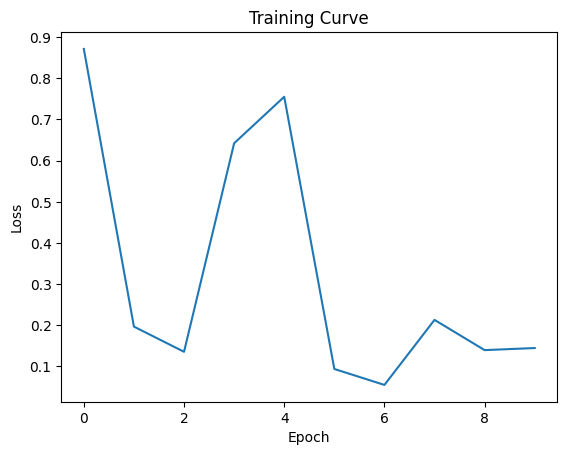

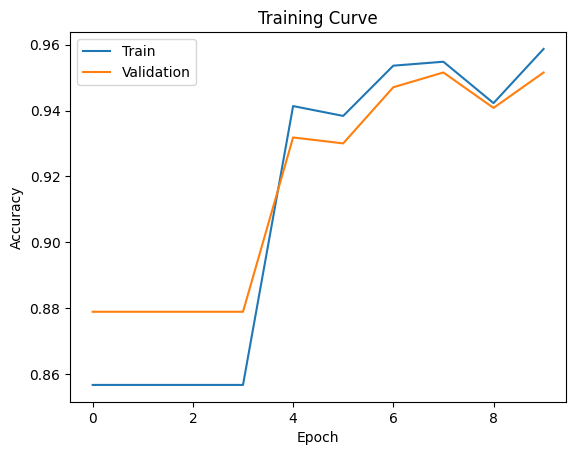

In [57]:

rnn = RNN(input_size, 100, 2)

train_rnn(rnn, train_data, val_data, num_epochs= 10, learning_rate=0.0001, batch_size= 32)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch 1; Loss 0.349175; Train Acc 0.957523; Val Acc 0.960538
Epoch 2; Loss 0.031769; Train Acc 0.944361; Val Acc 0.939013
Epoch 3; Loss 0.032455; Train Acc 0.961711; Val Acc 0.963229
Epoch 4; Loss 0.332774; Train Acc 0.974873; Val Acc 0.982960
Epoch 5; Loss 0.018092; Train Acc 0.969488; Val Acc 0.979372
Epoch 6; Loss 0.052632; Train Acc 0.976668; Val Acc 0.984753
Epoch 7; Loss 0.062721; Train Acc 0.941669; Val Acc 0.942601
Epoch 8; Loss 0.499400; Train Acc 0.927012; Val Acc 0.937220
Epoch 9; Loss 0.138769; Train Acc 0.968890; Val Acc 0.970404
Epoch 10; Loss 0.232530; Train Acc 0.931499; Val Acc 0.931839
Epoch 11; Loss 0.008402; Train Acc 0.940473; Val Acc 0.962332
Epoch 12; Loss 0.073965; Train Acc 0.977266; Val Acc 0.984753
Epoch 13; Loss 0.571197; Train Acc 0.977266; Val Acc 0.982960
Epoch 14; Loss 0.022422; Train Acc 0.963506; Val Acc 0.971300
Epoch 15; Loss 0.138106; Train Acc 0.976967; Val Acc 0.983857


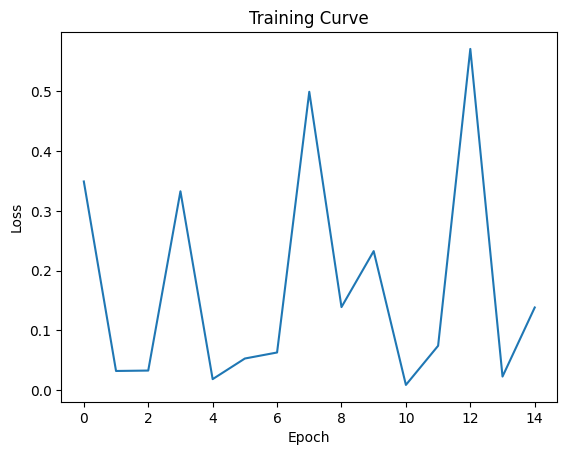

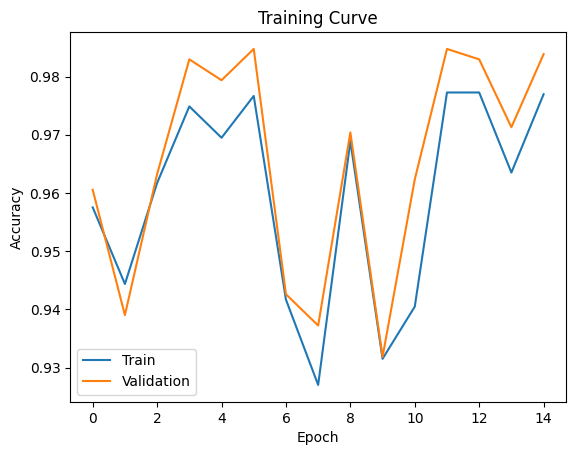

In [58]:
# Inreased number of epochs, increased number of hidden units, increased learning rate
# results are not smooth, fluctuate too much
model = RNN(input_size, 150, 2)
train_rnn(rnn, train_data, val_data, num_epochs= 15, learning_rate=0.0005, batch_size= 32)

Epoch 1; Loss 0.014067; Train Acc 0.977266; Val Acc 0.982960
Epoch 2; Loss 0.013753; Train Acc 0.977565; Val Acc 0.982960
Epoch 3; Loss 0.157488; Train Acc 0.977565; Val Acc 0.982960
Epoch 4; Loss 0.017709; Train Acc 0.977266; Val Acc 0.983857
Epoch 5; Loss 0.070606; Train Acc 0.977864; Val Acc 0.984753
Epoch 6; Loss 0.024734; Train Acc 0.977565; Val Acc 0.983857
Epoch 7; Loss 0.013677; Train Acc 0.977266; Val Acc 0.984753
Epoch 8; Loss 0.155545; Train Acc 0.977266; Val Acc 0.984753
Epoch 9; Loss 0.011778; Train Acc 0.977266; Val Acc 0.983857
Epoch 10; Loss 0.014228; Train Acc 0.977565; Val Acc 0.984753


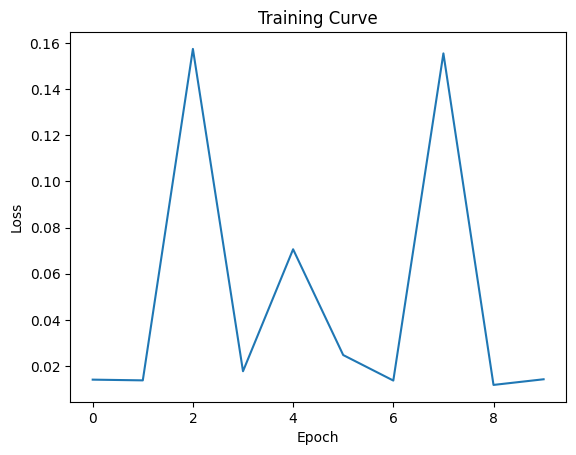

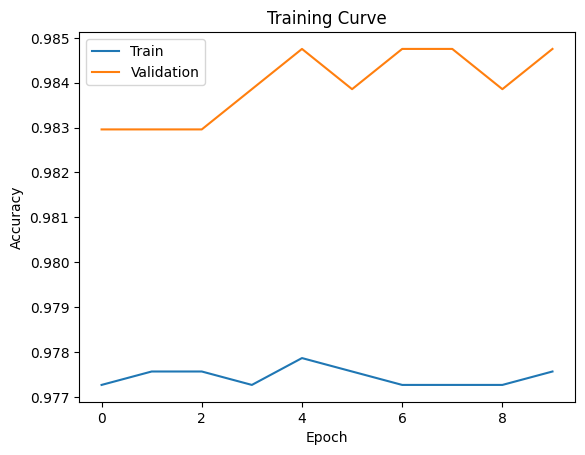

In [59]:
# increased num hidden layers, decreased learning rate and increased batch size to 64
# training accuracy are much lower, probably by chance (validation data happen to be easy)
model = RNN(input_size, 300, 2)
train_rnn(rnn, train_data, val_data, num_epochs= 10, learning_rate=0.00001, batch_size= 64)

Epoch 1; Loss 0.720275; Train Acc 0.143284; Val Acc 0.121076
Epoch 2; Loss 0.760667; Train Acc 0.143284; Val Acc 0.120179
Epoch 3; Loss 0.699649; Train Acc 0.165420; Val Acc 0.130942
Epoch 4; Loss 0.658917; Train Acc 0.840562; Val Acc 0.871749
Epoch 5; Loss 0.639152; Train Acc 0.856716; Val Acc 0.878924
Epoch 6; Loss 0.298903; Train Acc 0.856716; Val Acc 0.878924
Epoch 7; Loss 0.270111; Train Acc 0.856716; Val Acc 0.878924
Epoch 8; Loss 0.707007; Train Acc 0.856716; Val Acc 0.878924
Epoch 9; Loss 0.282615; Train Acc 0.856716; Val Acc 0.878924
Epoch 10; Loss 0.221550; Train Acc 0.856716; Val Acc 0.878924


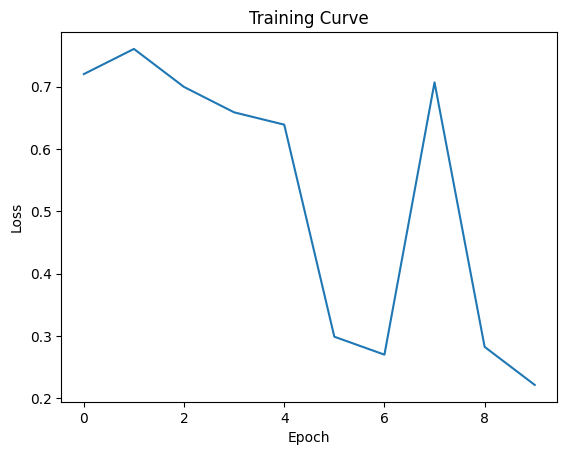

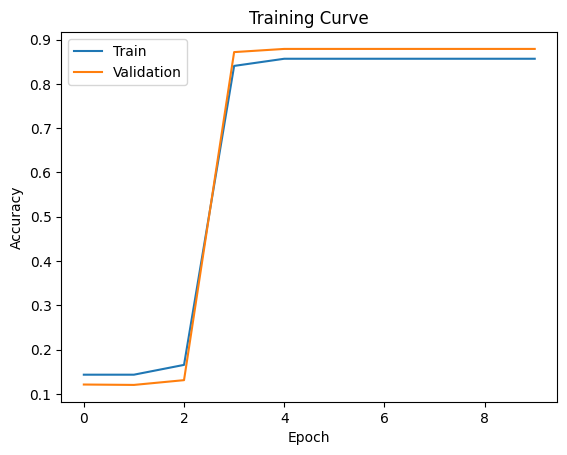

In [60]:
# increasing hidden layers are not effective, changed back to 100, decreased learning rate, increased batch size
# changed num epochs back to 10 as previous changes were not helpful
rnn = RNN(input_size, 100, 2)
train_rnn(rnn, train_data, val_data, num_epochs= 10, learning_rate=0.00001, batch_size= 32)
# best results

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [61]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [s for s in val_data.examples if s.label == 1],
    val_data.fields)
valid_spam_stuff = torchtext.data.BucketIterator(
                    valid_spam,
                    batch_size=32,
                    sort_key=lambda x: len(x.sms), # to minimize padding
                    sort_within_batch=True,        # sort within each batch
                    repeat=False)                  # repeat the iterator for many epochs
# Create a Dataset of only non-spam validation examples

valid_nospam = torchtext.data.Dataset(
    [s for s in val_data.examples if s.label == 1],
    val_data.fields)

valid_nospam_stuff = torchtext.data.BucketIterator(
                    valid_spam,
                    batch_size=32,
                    sort_key=lambda x: len(x.sms), # to minimize padding
                    sort_within_batch=True,        # sort within each batch
                    repeat=False)                  # repeat the iterator for many epochs

### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [ ]:
# False Positive:

# Impact: A false positive occurs when the algorithm incorrectly classifies a
# legitimate message as spam. This means that a message that is important or
# desired by the user is mistakenly flagged as unwanted or malicious.

# Impact on User: The impact of a false positive on the phone's user can be
# significant. It can lead to missing important messages, such as work-related
# emails, personal communication, or critical notifications. If the false
# positive rate is high, it could result in frustration, missed opportunities,
# and decreased productivity for the user. Additionally, if important messages
# are consistently marked as spam, the user may lose trust in the spam detection
# system and disable it altogether, leaving them vulnerable to actual spam.



# False Negative:

# Impact: A false negative occurs when the algorithm fails to detect a spam message,
# incorrectly classifying it as legitimate. This means that a potentially harmful
# or unwanted message slips through the filter and reaches the user's inbox.

# Impact on User: The impact of a false negative can also be significant, but
# in a different way. If a spam message reaches the user's inbox, it may lead to
# annoyance, distraction, or even exposure to malicious content such as phishing
# scams, malware, or fraudulent schemes. Depending on the nature of the spam message,
# it could also pose security risks or compromise the user's privacy. While a single
# false negative may not have a major impact, repeated occurrences could erode the
# user's trust in the spam detection system and undermine their confidence in the
# security of their device.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [71]:
test = torchtext.data.BucketIterator(test_data,batch_size=64,sort_key=lambda x: len(x.sms), sort_within_batch=True,repeat=False)
print("Final testing accuracy:", np.round(get_accuracy(rnn, test), 4)*100,"%")

Final testing accuracy: 88.06 %


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [109]:
def get_accuracy(model, data):
  """ Compute the accuracy of the `model` across a dataset `data`

  Example usage:

  >>> model = MyRNN() # to be defined
  >>> get_accuracy(model, valid) # the variable `valid` is from above
  """

  correct0, correct1, total0, total1 = 0, 0, 0, 0

  for sms, label in data:
      # Iterate over each element in the label tensor
      for l in label:
          # Compare each element with integer values 0 and 1
          if l.item() == 1:
              output1 = model(sms[0])
              pred1 = output1.max(1, keepdim=True)[1]
              correct1 += pred1.eq(l).sum().item()  # Remove view_as and shape mismatch
              total1 += 1  # Increment total count by 1 for each sample
          elif l.item() == 0:
              output0 = model(sms[0])
              pred0 = output0.max(1, keepdim=True)[1]
              correct0 += pred0.eq(l).sum().item()  # Remove view_as and shape mismatch
              total0 += 1  # Increment total count by 1 for each sample

  # Calculate accuracy for each class
  accuracy0 = correct0 / total0 if total0 > 0 else 0
  accuracy1 = correct1 / total1 if total1 > 0 else 0

  return accuracy0, accuracy1


In [113]:
fp, fn= get_accuracy(rnn, test)


In [115]:
print("False positive:", fp,"%")
print("False negative:", fn,"%")

# In this case, the false positive rate is approximately 63.07%, indicating that
# around 63.07% of non-spam messages were incorrectly classified as spam.

# The false negative rate is 0.0%, suggesting that no spam messages were incorrectly
# classified as non-spam, which is an ideal outcome but may indicate overfitting
# or other issues that need further investigation.


False positive: 63.07033639143731 %
False negative: 0.0 %


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [73]:
msg = "machine learning is sooo cool!"

In [76]:
test_tensor= torch.tensor([[text_field.vocab.stoi[letter] for letter in msg]])
res = rnn(test_tensor)

print(res)
# it's not spam

tensor([[ 0.7200, -0.9511]], grad_fn=<AddmmBackward0>)


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [ ]:
'''
Detecting spam can be both challenging and complicated due to the evolving nature
of spam techniques and the need to balance between minimizing false positives and
false negatives. Building a simple baseline model for spam detection can serve as
a benchmark to compare against more complex models like RNNs.

Outline to build such a baseline model:
    1. Feature Engineering: Extract basic characteristics from the text data,
    such as word count, character count, presence of specific keywords indicative
    of spam, URLs, and excessive capitalization.

    2. Model Construction: Employ a straightforward classification algorithm,
    like logistic regression or Bayes, utilizing the extracted features as
    input. Train the model on labeled data containing both spam and non-spam examples.

    3. Evaluation: Check the model's effectiveness using standard evaluation
    metrics like accuracy, precision, recall, and F1-score. Compare its performance
    against more sophisticated models to understand its relative efficacy.

    4. Iterate and Improve: Continuously refine the model by experimenting with
    various feature combinations, algorithms, and preprocessing techniques.
    Iterate on the model-building process iteratively to enhance its spam detection
    capabilities.

'''